<a href="https://colab.research.google.com/github/Sayan836/Identification-of-Medicinal-Plants/blob/master/Medicinal_Plants_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTALLING THE REQUIRED PACKAGES**

In [1]:
import pandas as pd
import shutil
import os
import glob
import seaborn as sns

import cv2
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file_path = "/content/drive/MyDrive/Projects/Medcinal_plants_dataset.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

**LOADING THE DATA**

In [4]:
dataset_path = '/content/Medicinal plant dataset'
image_paths=[image_path for image_path in glob.glob(dataset_path+'/*/*')]
image_categories=[os.path.basename(os.path.dirname(image_path)) for image_path in image_paths]
filenames=[os.path.basename(image_path) for image_path in image_paths]

doc = pd.DataFrame({'image_paths':image_paths,'filename':filenames,'image_category':image_categories})
doc.sort_values('image_category',inplace=True)
doc

,image_paths,filename,image_category
1935,/content/Medicinal plant dataset/Aloevera/4278...,4278.jpg,Aloevera
2001,/content/Medicinal plant dataset/Aloevera/4264...,4264.jpg,Aloevera
2002,/content/Medicinal plant dataset/Aloevera/4239...,4239.jpg,Aloevera
2003,/content/Medicinal plant dataset/Aloevera/4305...,4305.jpg,Aloevera
2004,/content/Medicinal plant dataset/Aloevera/4261...,4261.jpg,Aloevera
...,...,...,...
533,/content/Medicinal plant dataset/Wood_sorel/92...,928.jpg,Wood_sorel
532,/content/Medicinal plant dataset/Wood_sorel/49...,4932.jpg,Wood_sorel
531,/content/Medicinal plant dataset/Wood_sorel/49...,4983.jpg,Wood_sorel
548,/content/Medicinal plant dataset/Wood_sorel/48...,4876.jpg,Wood_sorel


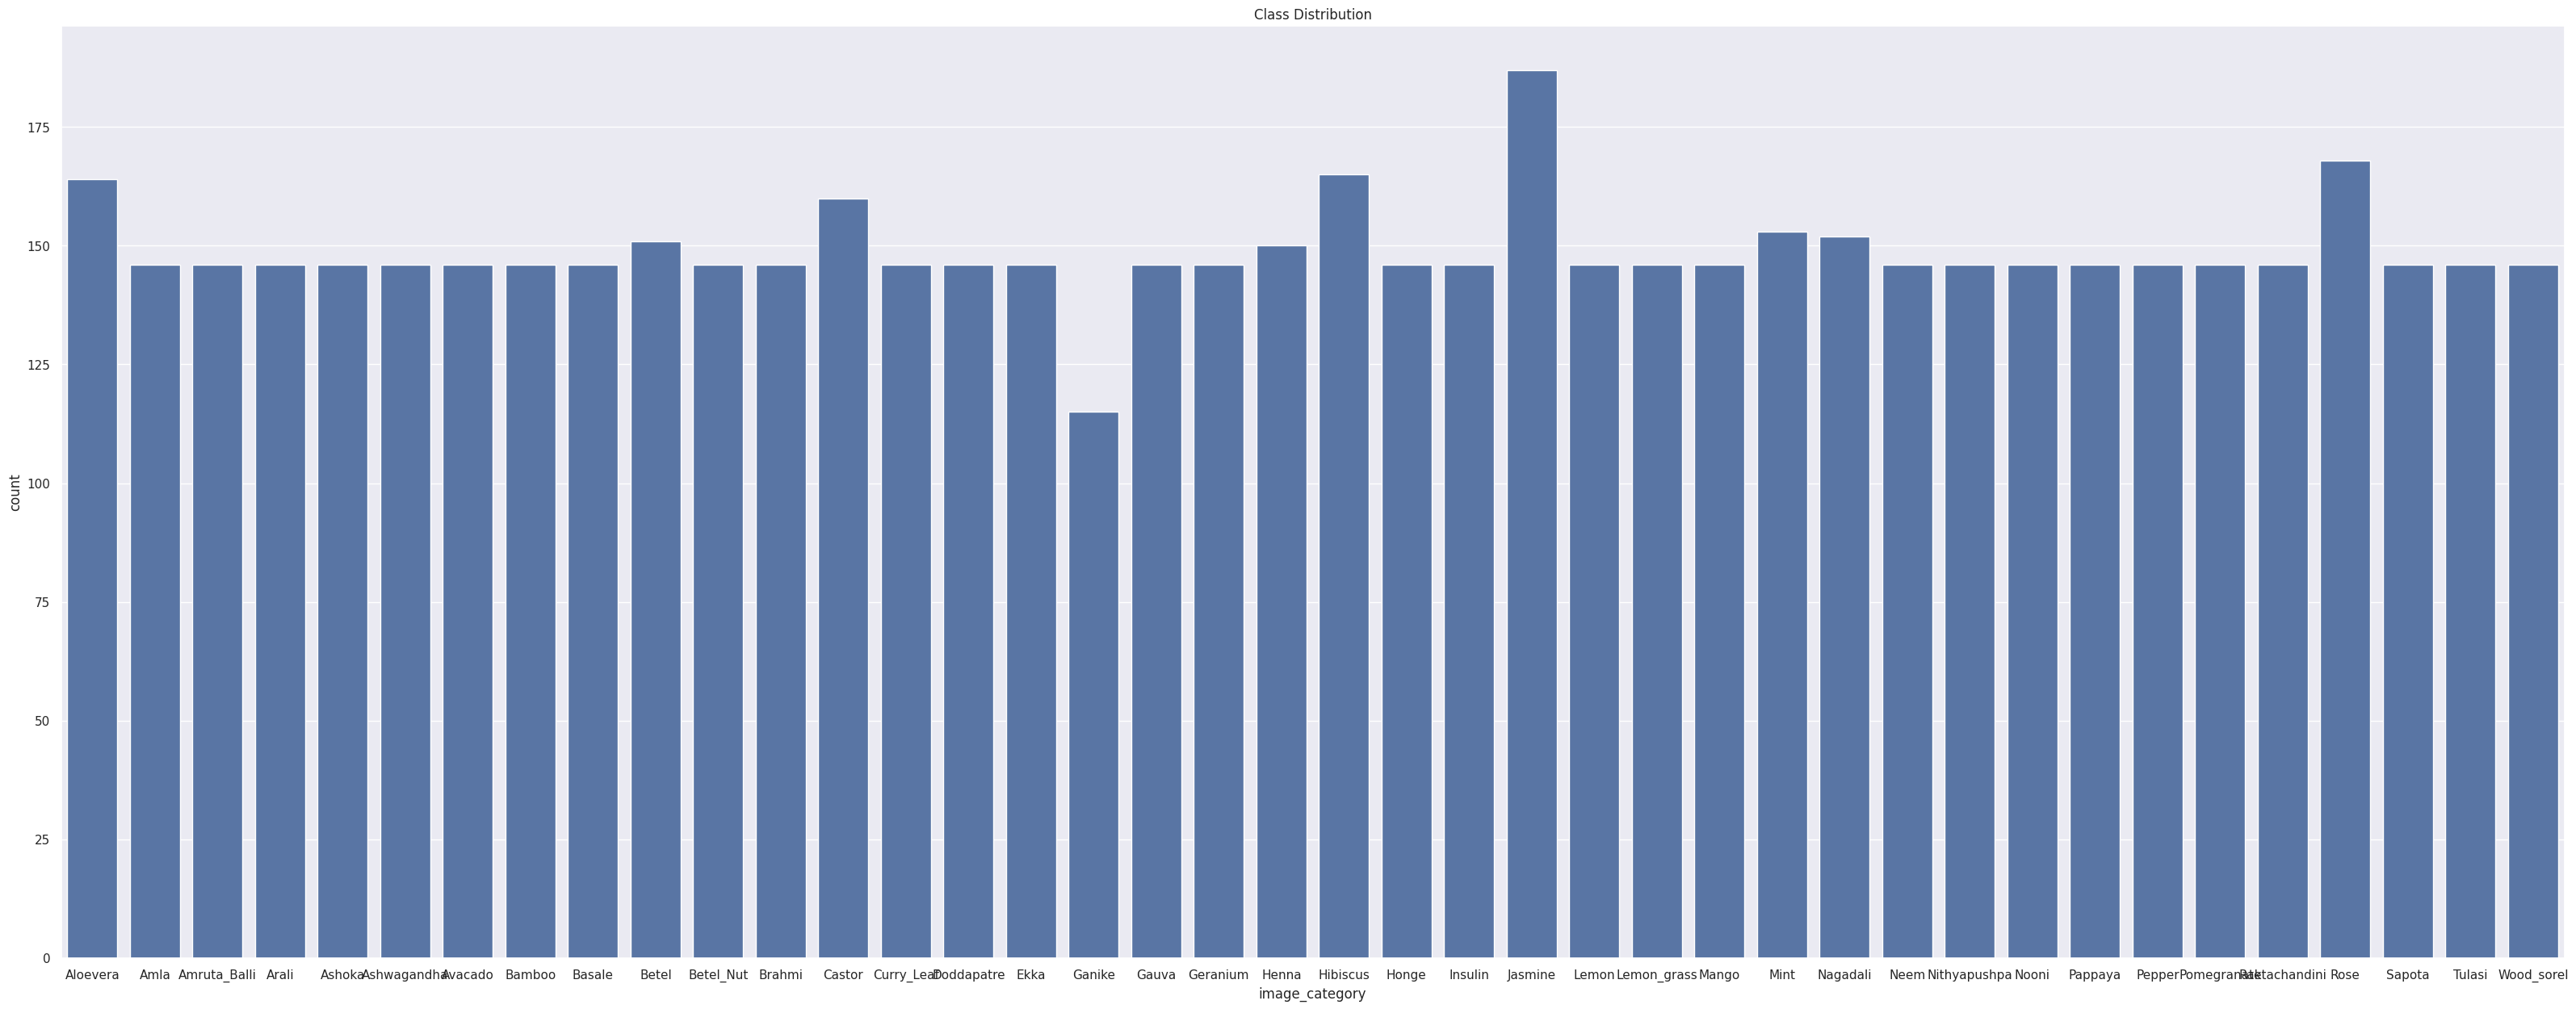

In [5]:
plt.figure(figsize=(40,15))
sns.set(style="darkgrid")
sns.countplot(x='image_category',data=doc)
plt.title('Class Distribution')
plt.show()

In [6]:
classes=doc['image_category'].unique()
class_counts=doc['image_category'].value_counts()
print(class_counts)
print(len(class_counts))

Jasmine          187
Rose             168
Hibiscus         165
Aloevera         164
Castor           160
Mint             153
Nagadali         152
Betel            151
Henna            150
Bamboo           146
Ashwagandha      146
Avacado          146
Arali            146
Amruta_Balli     146
Amla             146
Ashoka           146
Ekka             146
Doddapatre       146
Curry_Leaf       146
Gauva            146
Honge            146
Brahmi           146
Betel_Nut        146
Basale           146
Nooni            146
Insulin          146
Geranium         146
Lemon_grass      146
Mango            146
Neem             146
Nithyapushpa     146
Lemon            146
Raktachandini    146
Pappaya          146
Pomegranate      146
Pepper           146
Tulasi           146
Sapota           146
Wood_sorel       146
Ganike           115
Name: image_category, dtype: int64
40


In [7]:
temp=pd.DataFrame(columns=['image_paths','filename','image_category'])
for c in classes:
  x=doc[doc['image_category']==c]
  temp=pd.concat([temp,x[:150]],axis=0)
doc=temp.sample(frac=1,random_state=42)
doc.drop('filename',axis=1,inplace=True)
doc.reset_index(drop=True,inplace=True)

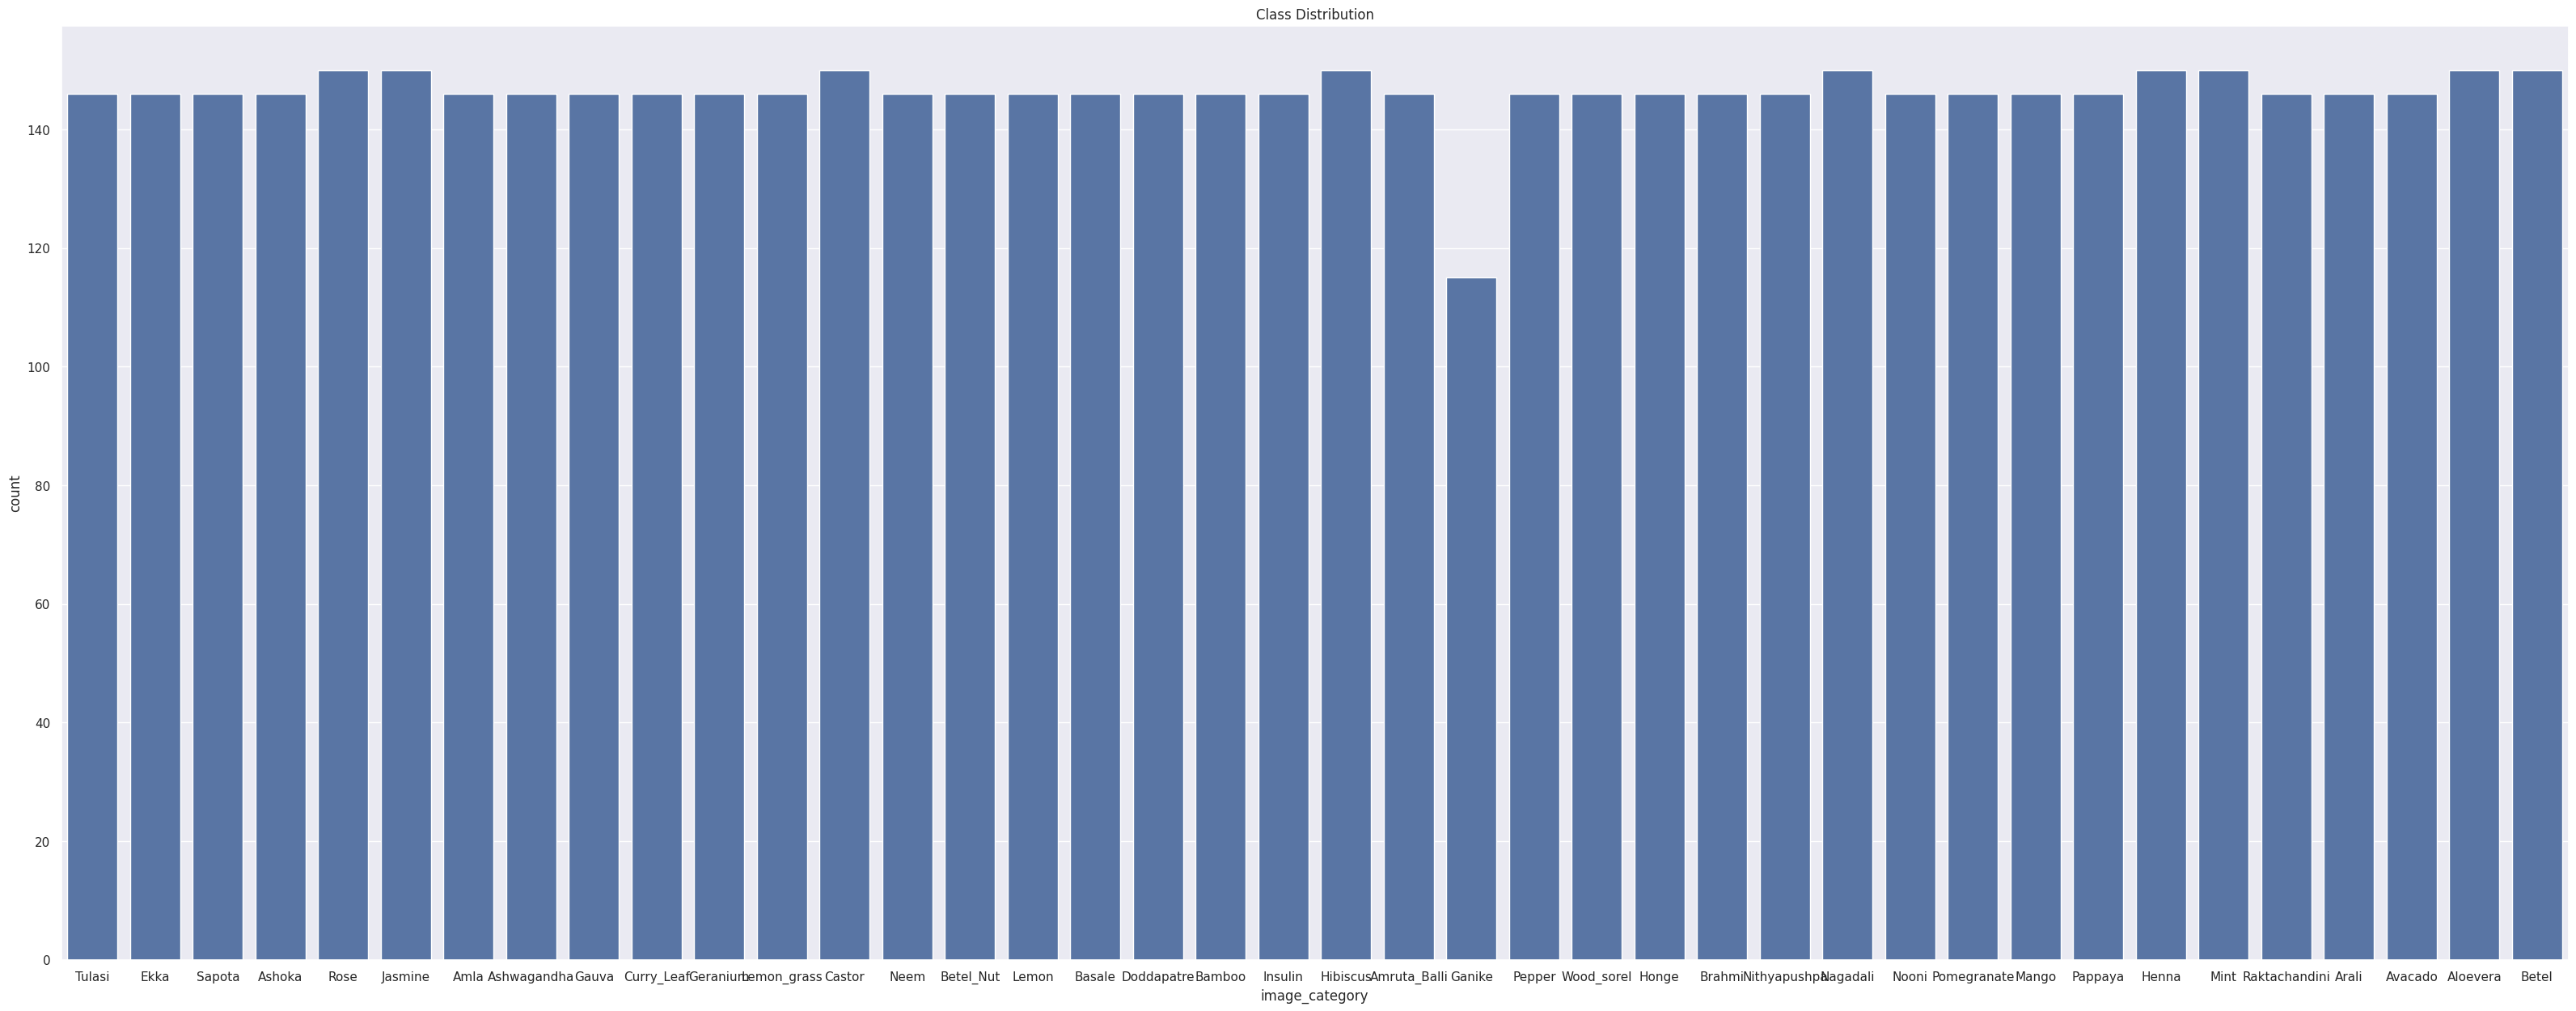

In [8]:
plt.figure(figsize=(40,15))
sns.countplot(x='image_category',data=doc)
plt.title('Class Distribution')
plt.show()

**DATA PREPROCESSING**

(283, 600, 3)


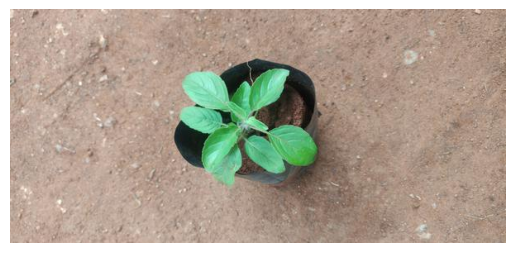

In [9]:
img=cv2.imread(doc['image_paths'][0])
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [10]:
test_size=0.1
train_df,test_df=train_test_split(doc,shuffle=True,test_size=test_size)
train_df

,image_paths,image_category
640,/content/Medicinal plant dataset/Lemon_grass/5...,Lemon_grass
5368,/content/Medicinal plant dataset/Brahmi/4776.jpg,Brahmi
1564,/content/Medicinal plant dataset/Betel_Nut/175...,Betel_Nut
1432,/content/Medicinal plant dataset/Neem/1861.jpg,Neem
1242,/content/Medicinal plant dataset/Hibiscus/1270...,Hibiscus
...,...,...
3178,/content/Medicinal plant dataset/Ekka/2618.jpg,Ekka
3477,/content/Medicinal plant dataset/Ekka/2554.jpg,Ekka
520,/content/Medicinal plant dataset/Amla/1390.jpg,Amla
4282,/content/Medicinal plant dataset/Amruta_Balli/...,Amruta_Balli


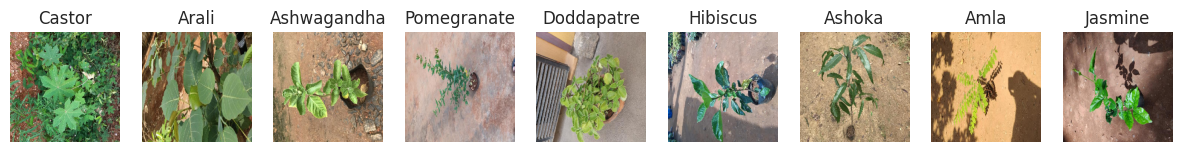

In [11]:
plt.figure(figsize=(15, 5))
random_samples = train_df.sample(9)

for i, (_, row) in enumerate(random_samples.iterrows()):
    image_path = row['image_paths']
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))  # Adjust target_size as needed
    image_array = tf.keras.preprocessing.image.img_to_array(image)

    plt.subplot(1, 9, i + 1)
    plt.imshow(image_array / 255.0)  # Normalize pixel values to [0, 1]
    plt.title(row['image_category'])
    plt.axis('off')

plt.show()

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col='image_category',
    target_size=(224,224),
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=20,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_paths',
    y_col='image_category',
    target_size=(224,224),
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=10,
    subset='validation'
)


test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_paths',
    y_col='image_category',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=10
)

Found 4208 validated image filenames belonging to 40 classes.
Found 1052 validated image filenames belonging to 40 classes.
Found 585 validated image filenames belonging to 40 classes.


In [14]:
print(train_images.class_indices)
labels = '\n'.join(sorted(train_images.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Aloevera': 0, 'Amla': 1, 'Amruta_Balli': 2, 'Arali': 3, 'Ashoka': 4, 'Ashwagandha': 5, 'Avacado': 6, 'Bamboo': 7, 'Basale': 8, 'Betel': 9, 'Betel_Nut': 10, 'Brahmi': 11, 'Castor': 12, 'Curry_Leaf': 13, 'Doddapatre': 14, 'Ekka': 15, 'Ganike': 16, 'Gauva': 17, 'Geranium': 18, 'Henna': 19, 'Hibiscus': 20, 'Honge': 21, 'Insulin': 22, 'Jasmine': 23, 'Lemon': 24, 'Lemon_grass': 25, 'Mango': 26, 'Mint': 27, 'Nagadali': 28, 'Neem': 29, 'Nithyapushpa': 30, 'Nooni': 31, 'Pappaya': 32, 'Pepper': 33, 'Pomegranate': 34, 'Raktachandini': 35, 'Rose': 36, 'Sapota': 37, 'Tulasi': 38, 'Wood_sorel': 39}


**MODEL**

In [15]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                 output_shape=[1280],
                 trainable=True),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(40, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240     
                                                                 
Total params: 2309224 (8.81 MB)
Trainable params: 2275112 (8.68 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


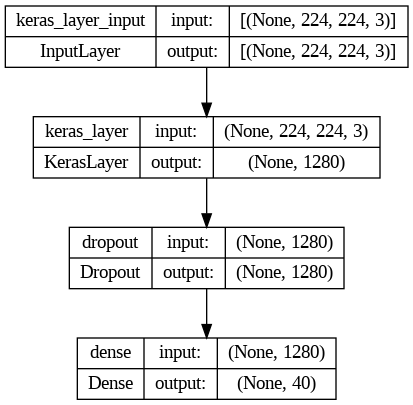

In [16]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
  optimizer=optimizer,
  loss='categorical_crossentropy',
  metrics=['acc'])

In [18]:
def lr_range_test(epoch):
    lr_start = 1e-4
    lr_exp_base = 1.05
    return lr_start * (lr_exp_base ** epoch)

LR_scheduler=tf.keras.callbacks.LearningRateScheduler(lr_range_test)

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

model_checkpoint= tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor='val_acc',
    save_best_only=True,
    mode='max',
    verbose=1
)

**TRAINING THE MODEL**

In [20]:
steps_per_epoch = np.ceil(train_images.samples/train_images.batch_size)
val_steps_per_epoch = np.ceil(val_images.samples/val_images.batch_size)

hist = model.fit(
    train_images,
    epochs=30,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_images,
    validation_steps=val_steps_per_epoch,
    callbacks=[model_checkpoint, tensorboard_callback])

Epoch 1/30
211/211 [==============================] - ETA: 0s - loss: 1.3308 - acc: 0.6526
Epoch 1: val_acc improved from -inf to 0.52852, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/211 [==============================] - 63s 136ms/step - loss: 1.3308 - acc: 0.6526 - val_loss: 2.5819 - val_acc: 0.5285
Epoch 2/30
211/211 [==============================] - ETA: 0s - loss: 0.6044 - acc: 0.8472
Epoch 2: val_acc improved from 0.52852 to 0.75380, saving model to best_model.h5
211/211 [==============================] - 25s 120ms/step - loss: 0.6044 - acc: 0.8472 - val_loss: 1.0976 - val_acc: 0.7538
Epoch 3/30
211/211 [==============================] - ETA: 0s - loss: 0.4920 - acc: 0.8793
Epoch 3: val_acc did not improve from 0.75380
211/211 [==============================] - 25s 120ms/step - loss: 0.4920 - acc: 0.8793 - val_loss: 1.8920 - val_acc: 0.6587
Epoch 4/30
211/211 [==============================] - ETA: 0s - loss: 0.4081 - acc: 0.9002
Epoch 4: val_acc did not improve from 0.75380
211/211 [==============================] - 26s 122ms/step - loss: 0.4081 - acc: 0.9002 - val_loss: 1.7948 - val_acc: 0.6616
Epoch 5/30
211/211 [==============================] - ETA:

**EVALUATION GRAPHS**

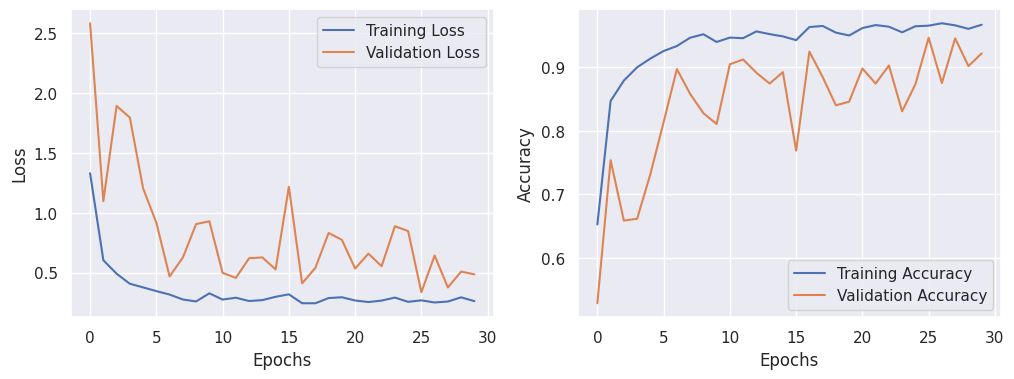

In [21]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['acc'], label='Training Accuracy')
plt.plot(hist.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**TESTING THE TRAINED MODEL**

In [22]:

test_loss,test_accuracy=model.evaluate(test_images)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

59/59 [==============================] - 3s 49ms/step - loss: 0.5358 - acc: 0.9214
Test Loss: 0.5358
Test Accuracy: 0.9214


**MAKING SOME REAL-TIME PREDICTION USING THE BEST MODEL SO FAR**

1/1 [==============================] - 1s 1s/step
[27]
Predicted label: Mint


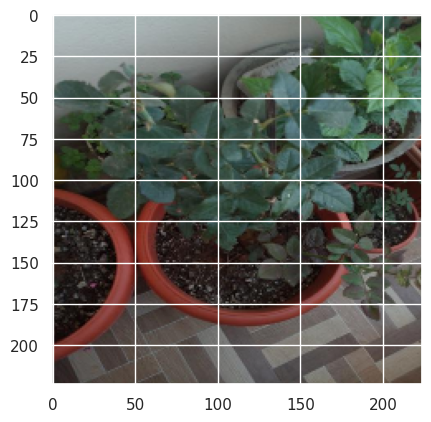

In [23]:

model.load_weights('best_model.h5')
model.evaluate(test_images)
img=cv2.imread(train_df['image_paths'][5250])
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))
img=np.array(img)
img=img.reshape(1,224,224,3)

pred=model.predict(img)
pred=np.argmax(pred,axis=1)
print(pred)
dic=train_images.class_indices
print("Predicted label:",list(dic.keys())[pred[0]])
plt.imshow(img.reshape(224,224,3))